# Ejercicio 10 
## Pipeline de Regresión: Auto MPG UCI


**Dataset:** Auto MPG - UCI Machine Learning Repository

**Fuente:** https://archive.ics.uci.edu/dataset/9/auto+mpg

**Objetivo:** Predecir el consumo de combustible (MPG) de vehículos.

**Modelos:** SVR, Random Forest, Gradient Boosting, MLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

## 2. Carga del Dataset

In [2]:
data = pd.read_csv('auto-mpg.csv')
print(f'Dataset cargado: {data.shape}')
data.head()

Dataset cargado: (398, 7)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model-year
0,18.0,8,307.0,130.0,3504,12.0,70
1,15.0,8,350.0,165.0,3693,11.5,70
2,18.0,8,318.0,150.0,3436,11.0,70
3,16.0,8,304.0,150.0,3433,12.0,70
4,17.0,8,302.0,140.0,3449,10.5,70


In [3]:
# Verificar y limpiar valores nulos
print("Valores nulos por columna:")
print(data.isnull().sum())

# Eliminar filas con valores nulos 
data = data.dropna()
print(f"\nDataset después de limpiar: {data.shape[0]} filas")

Valores nulos por columna:
mpg             0
cylinders       0
displacement    0
horsepower      2
weight          0
acceleration    0
model-year      0
dtype: int64

Dataset después de limpiar: 396 filas


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           396 non-null    float64
 1   cylinders     396 non-null    int64  
 2   displacement  396 non-null    float64
 3   horsepower    396 non-null    float64
 4   weight        396 non-null    int64  
 5   acceleration  396 non-null    float64
 6   model-year    396 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 24.8 KB


In [5]:
data.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model-year
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,23.517172,5.457071,193.650253,104.189394,2973.000000,15.555808,76.027778
std,7.834368,1.703511,104.422387,38.402030,847.690354,2.758295,3.696969
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.375000,4.000000,104.750000,75.000000,2225.250000,13.800000,73.000000
50%,23.000000,4.000000,148.500000,92.000000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,263.250000,125.000000,3610.000000,17.125000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [6]:
# Convertir horsepower 
if data['horsepower'].dtype == 'object':
    data['horsepower'] = pd.to_numeric(data['horsepower'], errors='coerce')
    data['horsepower'].fillna(data['horsepower'].median(), inplace=True)
    print('Horsepower convertido y nulos imputados')

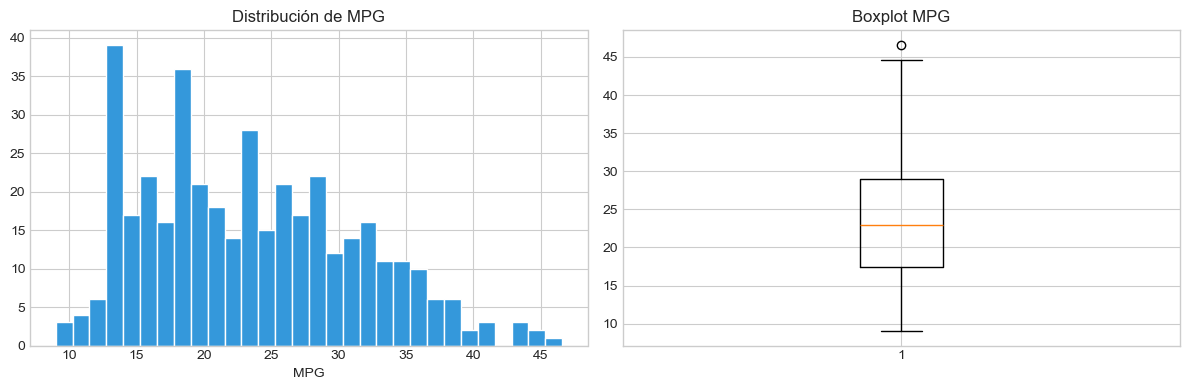

In [7]:
# Visualización de MPG
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(data['mpg'], bins=30, color='#3498db', edgecolor='white')
axes[0].set_xlabel('MPG')
axes[0].set_title('Distribución de MPG')
axes[1].boxplot(data['mpg'])
axes[1].set_title('Boxplot MPG')
plt.tight_layout()
plt.savefig('distribucion_mpg.png', dpi=150)
plt.show()

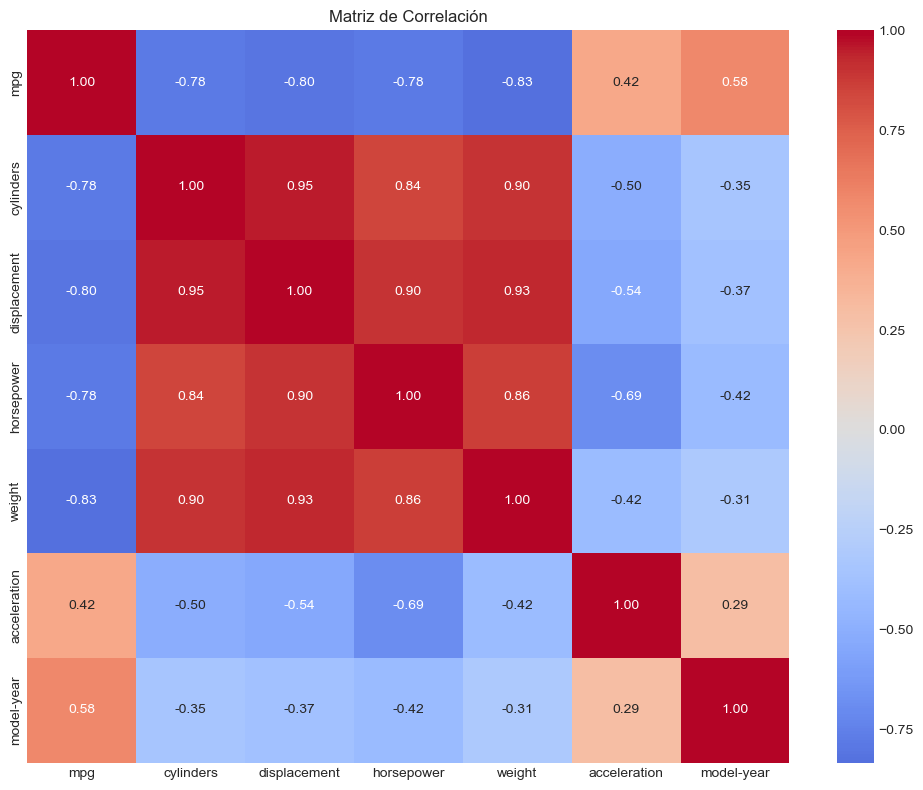

In [8]:
# Matriz de correlación
numeric_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.savefig('correlacion_regresion.png', dpi=150)
plt.show()

## 3. Preprocesamiento

In [9]:
feature_cols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model-year']

X = data[feature_cols].copy()
y = data['mpg'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train: {len(X_train)}, Test: {len(X_test)}')

Train: 316, Test: 80


## 4. Entrenamiento de Modelos

In [10]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
# SVR

pipe_svr = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
param_svr = {'svr__C': [0.1, 1, 10, 100], 'svr__epsilon': [0.01, 0.1, 0.5], 'svr__gamma': ['scale', 'auto'], 'svr__kernel': ['rbf', 'linear']}

t0 = time()
grid_svr = GridSearchCV(pipe_svr, param_svr, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_svr.fit(X_train, y_train)
tiempo_svr = time() - t0

print(f'Mejores params: {grid_svr.best_params_}')
print(f'Mejor MSE CV: {-grid_svr.best_score_:.4f}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores params: {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
Mejor MSE CV: 8.1369


In [12]:
# Random Forest

pipe_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42))])
param_rf = {'rf__n_estimators': [50, 100, 200], 'rf__max_depth': [None, 10, 20], 'rf__min_samples_split': [2, 5, 10]}

t0 = time()
grid_rf = RandomizedSearchCV(pipe_rf, param_rf, n_iter=30, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)
grid_rf.fit(X_train, y_train)
tiempo_rf = time() - t0

print(f'Mejores params: {grid_rf.best_params_}')
print(f'Mejor MSE CV: {-grid_rf.best_score_:.4f}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores params: {'rf__n_estimators': 50, 'rf__min_samples_split': 2, 'rf__max_depth': 10}
Mejor MSE CV: 8.3782


In [13]:
# Gradient Boosting

pipe_gb = Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingRegressor(random_state=42))])
param_gb = {'gb__n_estimators': [50, 100, 200], 'gb__learning_rate': [0.01, 0.1, 0.2], 'gb__max_depth': [3, 5, 7]}

t0 = time()
grid_gb = GridSearchCV(pipe_gb, param_gb, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_gb.fit(X_train, y_train)
tiempo_gb = time() - t0

print(f'Mejores params: {grid_gb.best_params_}')
print(f'Mejor MSE CV: {-grid_gb.best_score_:.4f}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores params: {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 100}
Mejor MSE CV: 8.9249


In [14]:
# MLP

pipe_mlp = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(random_state=42, max_iter=1000, early_stopping=True))])
param_mlp = {'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], 'mlp__activation': ['relu', 'tanh'], 'mlp__alpha': [0.0001, 0.001, 0.01]}

t0 = time()
grid_mlp = RandomizedSearchCV(pipe_mlp, param_mlp, n_iter=30, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)
grid_mlp.fit(X_train, y_train)
tiempo_mlp = time() - t0

print(f'Mejores params: {grid_mlp.best_params_}')
print(f'Mejor MSE CV: {-grid_mlp.best_score_:.4f}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores params: {'mlp__hidden_layer_sizes': (100,), 'mlp__alpha': 0.01, 'mlp__activation': 'relu'}
Mejor MSE CV: 10.0840


## 5. Evaluación y Comparación

In [15]:
def evaluar_regresion(nombre, grid, X_test, y_test):
    y_pred = grid.best_estimator_.predict(X_test)
    return {
        'Modelo': nombre,
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred) * 100,
        'R2': r2_score(y_test, y_pred),
        'y_pred': y_pred
    }

modelos = {'SVR': grid_svr, 'Random Forest': grid_rf, 'Gradient Boosting': grid_gb, 'MLP': grid_mlp}
resultados = [evaluar_regresion(n, g, X_test, y_test) for n, g in modelos.items()]

for r in resultados:
    print(f"\n{r['Modelo']}: R2={r['R2']:.4f}, RMSE={r['RMSE']:.2f}, MAE={r['MAE']:.2f}")


SVR: R2=0.8753, RMSE=2.54, MAE=1.81

Random Forest: R2=0.8799, RMSE=2.50, MAE=1.65

Gradient Boosting: R2=0.8588, RMSE=2.71, MAE=1.79

MLP: R2=0.8080, RMSE=3.16, MAE=2.14


In [16]:
# Tabla de resultados
df_resultados = pd.DataFrame(resultados)
df_display = df_resultados[['Modelo', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2']]
print('TABLA COMPARATIVA - REGRESIÓN')
print(df_display.to_string(index=False))
df_display.to_csv('resultados_regresion.csv', index=False)

TABLA COMPARATIVA - REGRESIÓN
           Modelo      MSE     RMSE      MAE      MAPE       R2
              SVR 6.470892 2.543795 1.813663  8.127663 0.875278
    Random Forest 6.229266 2.495850 1.647285  7.670697 0.879936
Gradient Boosting 7.324635 2.706406 1.785695  8.065309 0.858823
              MLP 9.959262 3.155830 2.142564 10.184704 0.808043


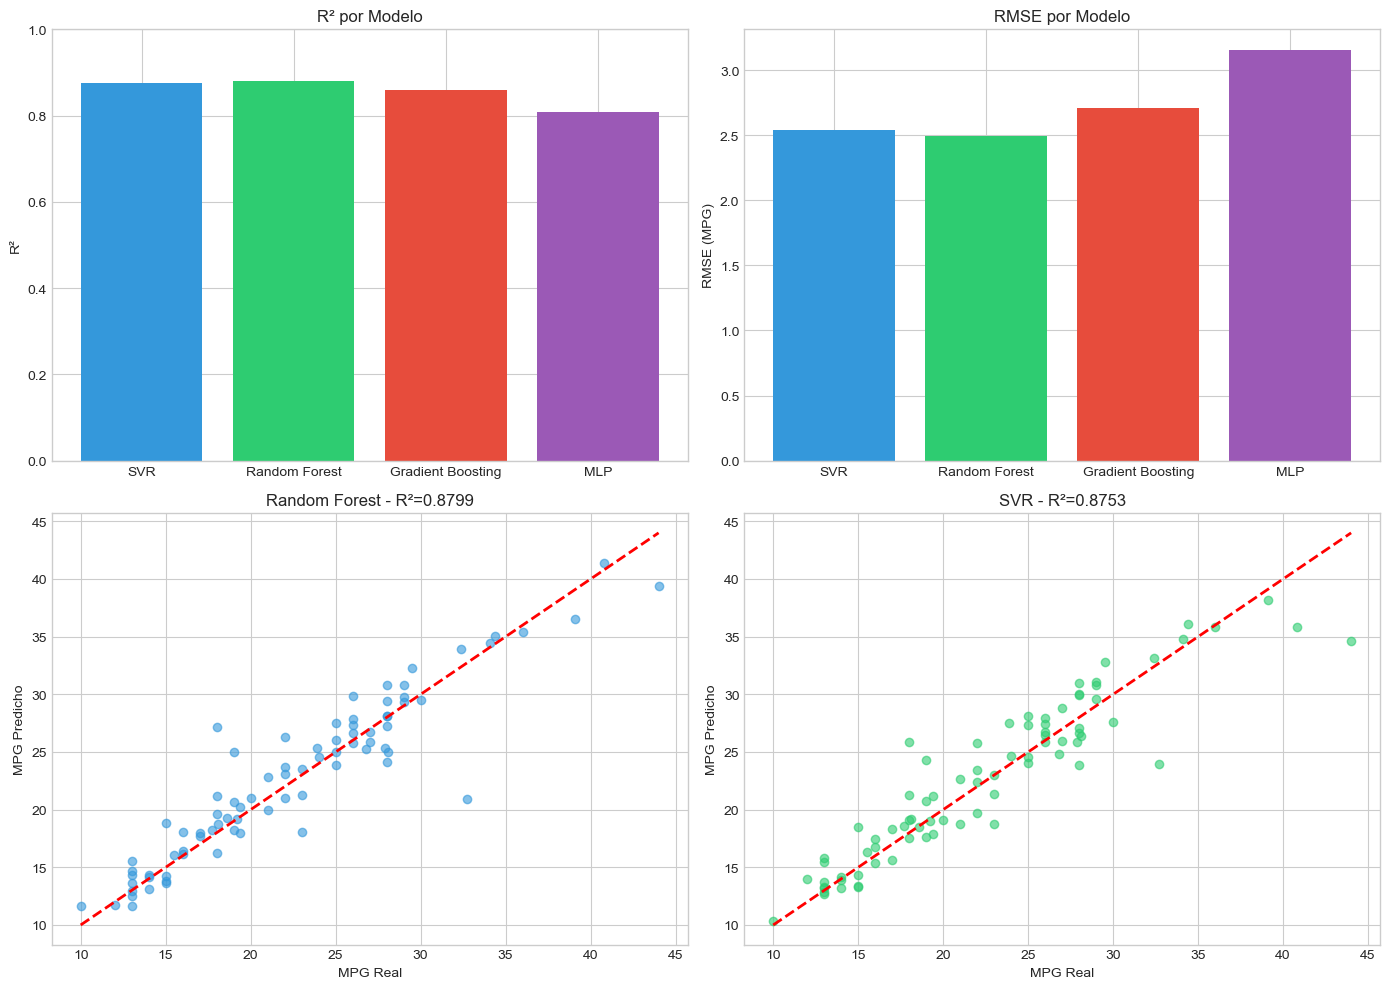

In [17]:
# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colores = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

# R2
ax1 = axes[0, 0]
ax1.bar(df_resultados['Modelo'], df_resultados['R2'], color=colores)
ax1.set_ylabel('R²')
ax1.set_title('R² por Modelo')
ax1.set_ylim(0, 1)

# RMSE
ax2 = axes[0, 1]
ax2.bar(df_resultados['Modelo'], df_resultados['RMSE'], color=colores)
ax2.set_ylabel('RMSE (MPG)')
ax2.set_title('RMSE por Modelo')

# Predicciones vs Reales (mejores 2)
df_sorted = df_resultados.sort_values('R2', ascending=False)
for i, (_, row) in enumerate(df_sorted.head(2).iterrows()):
    ax = axes[1, i]
    ax.scatter(y_test, row['y_pred'], alpha=0.6, color=colores[i])
    lims = [min(y_test.min(), row['y_pred'].min()), max(y_test.max(), row['y_pred'].max())]
    ax.plot(lims, lims, 'r--', lw=2)
    ax.set_xlabel('MPG Real')
    ax.set_ylabel('MPG Predicho')
    ax.set_title(f"{row['Modelo']} - R²={row['R2']:.4f}")

plt.tight_layout()
plt.savefig('comparacion_regresion.png', dpi=150)
plt.show()

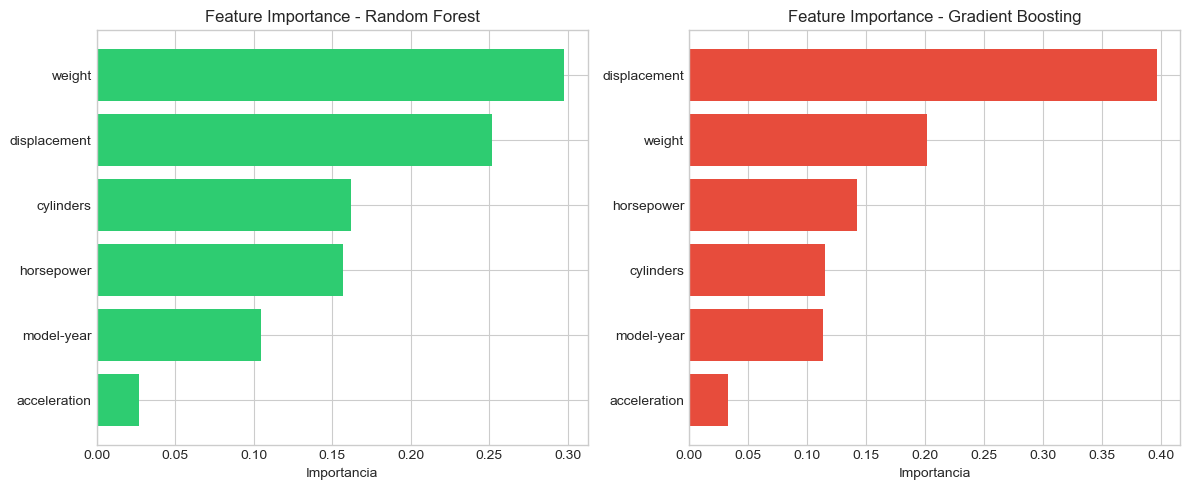

In [18]:
# Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (name, model_key) in enumerate([('Random Forest', 'rf'), ('Gradient Boosting', 'gb')]):
    grid = modelos[name]
    imp = grid.best_estimator_.named_steps[model_key].feature_importances_
    idx = np.argsort(imp)[::-1]
    axes[i].barh(range(len(imp)), imp[idx], color=colores[i+1])
    axes[i].set_yticks(range(len(imp)))
    axes[i].set_yticklabels([feature_cols[j] for j in idx])
    axes[i].set_xlabel('Importancia')
    axes[i].set_title(f'Feature Importance - {name}')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

In [19]:
# Hiperparámetros
print('MEJORES HIPERPARÁMETROS')
for nombre, grid in modelos.items():
    print(f'\n{nombre}:')
    for p, v in grid.best_params_.items():
        print(f'  {p.split("__")[-1]}: {v}')

MEJORES HIPERPARÁMETROS

SVR:
  C: 10
  epsilon: 0.01
  gamma: auto
  kernel: rbf

Random Forest:
  n_estimators: 50
  min_samples_split: 2
  max_depth: 10

Gradient Boosting:
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 100

MLP:
  hidden_layer_sizes: (100,)
  alpha: 0.01
  activation: relu
